In [1]:
# Home Credit Default Risk

import os
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

HOME_CREDIT_PATH = os.path.join("datasets", "HomeCredit")

def load_home_credit_data(filename, home_credit_path=HOME_CREDIT_PATH):
    csv_path = os.path.join(home_credit_path, filename)
    return pd.read_csv(csv_path)

def load_bureau_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    bureau = pd.read_csv(os.path.join(home_credit_path, "bureau.csv"))
    bureau_balance = pd.read_csv(os.path.join(home_credit_path, "bureau_balance.csv"))
    
    # grouped
    bb_agg = {'MONTHS_BALANCE': ['mean', 'size']}
    selected_bureau = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_agg)
    
    # 返却用データフレームに格納
    agg_bureau = pd.DataFrame()
    agg_bureau['MONTHS_BALANCE_MEAN'] = selected_bureau.loc[:, ('MONTHS_BALANCE', 'mean')]
    agg_bureau['MONTHS_BALANCE_SIZE'] = selected_bureau.loc[:, ('MONTHS_BALANCE', 'size')]
    agg_bureau['BALANCE_CNT'] = bureau_balance.groupby('SK_ID_BUREAU').size().reset_index().iloc[:, 1]
    agg_bureau['STATUS'] = bureau_balance.groupby(['SK_ID_BUREAU', 'STATUS']).size().unstack().idxmax(1)
    agg_bureau = agg_bureau.reset_index()

    # merge
    agg_bureau = bureau.merge(agg_bureau,
                    on='SK_ID_BUREAU', how='left')
    
    # aggregate
    bureau_agg = {
        'DAYS_CREDIT': ['mean', 'min', 'max', 'sum'],
        'CREDIT_DAY_OVERDUE': ['sum', 'mean', 'max'],
        'DAYS_CREDIT_ENDDATE': ['mean', 'min', 'max', 'sum'],
        'DAYS_ENDDATE_FACT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'min', 'max', 'sum'],
        'CNT_CREDIT_PROLONG': ['min', 'max'],
        'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'min', 'max', 'sum'],
        'AMT_ANNUITY': ['sum', 'mean', 'max'],
        'MONTHS_BALANCE_MEAN': ['sum', 'max'],
        'MONTHS_BALANCE_SIZE': ['sum', 'max'],
        'BALANCE_CNT': ['sum', 'max'],
    }
    merged_bureau = agg_bureau.groupby('SK_ID_CURR').agg(bureau_agg)
    
    # 特徴量の追加 
    cols = merged_bureau.columns.tolist()
    df_bureau = pd.DataFrame() # 返却用のデータフレーム生成
    for col in cols:
        df_bureau['BUREAU_' + col[0] + "_" + col[1].upper()] = merged_bureau.loc[:, (col[0], col[1])]
    df_bureau['BUREAU_CREDIT_ACTIVE'] = bureau.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE']).size().unstack().idxmax(1)
    df_bureau['BUREAU_CREDIT_CURRENCY'] = bureau.groupby(['SK_ID_CURR', 'CREDIT_CURRENCY']).size().unstack().idxmax(1)
    df_bureau['BUREAU_CREDIT_TYPE'] = bureau.groupby(['SK_ID_CURR', 'CREDIT_TYPE']).size().unstack().idxmax(1)
    df_bureau['BUREAU_STATUS'] = agg_bureau.groupby(['SK_ID_CURR', 'STATUS']).size().unstack().idxmax(1)
    df_bureau['BUREAU_CREDIT_DEBT_MEAN_PERCENT'] = df_bureau['BUREAU_AMT_CREDIT_SUM_MEAN'] / df_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_MEAN'].replace(0, np.nan)
    df_bureau['BUREAU_CREDIT_DEBT_MAX_PERCENT'] = df_bureau['BUREAU_AMT_CREDIT_SUM_MAX'] / df_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_MAX'].replace(0, np.nan)
    df_bureau['BUREAU_DEBT_LIMIT_MEAN_PERCENT'] =  df_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_MEAN'] / df_bureau['BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN'].replace(0, np.nan)
    df_bureau['BUREAU_DEBT_LIMIT_SUM_PERCENT'] =  df_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM'] / df_bureau['BUREAU_AMT_CREDIT_SUM_LIMIT_SUM'].replace(0, np.nan)
    df_bureau['BUREAU_DEBT_LIMIT_MAX_PERCENT'] =  df_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_MAX'] / df_bureau['BUREAU_AMT_CREDIT_SUM_LIMIT_MAX'].replace(0, np.nan)
    df_bureau = df_bureau.reset_index()
    
    del bureau, bureau_balance, selected_bureau, agg_bureau, merged_bureau
    gc.collect()
    return df_bureau

def load_pos_cash_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    pos_cash = pd.read_csv(os.path.join(home_credit_path, "POS_CASH_balance.csv"))
    
    # grouped
    pos_cash_num_agg = {
        'MONTHS_BALANCE': ['sum', 'mean', 'max', 'size', 'var'],
        'CNT_INSTALMENT': ['mean', 'max'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'max'],
        'SK_DPD': ['mean', 'max'],
        'SK_DPD_DEF': ['mean', 'max'],
    }
    grouped_pos = pos_cash.groupby('SK_ID_CURR').agg(pos_cash_num_agg)
    
    # 特徴量の追加
    cols = grouped_pos.columns.tolist()
    agg_pos = pd.DataFrame() # 返却用のデータフレーム生成
    for col in cols:
        agg_pos['POS_' + col[0] + "_" + col[1].upper()] = grouped_pos.loc[:, (col[0], col[1])]
    agg_pos['POS_BALANCE_CNT'] = pos_cash.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    agg_pos['PAY_NAME_CONTRACT_STATUS'] = pos_cash.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS']) \
        .size().unstack().idxmax(1)
    agg_pos = agg_pos.reset_index()
    
    del pos_cash, grouped_pos
    gc.collect()
    return agg_pos

def load_installments_payments_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    payment = pd.read_csv(os.path.join(home_credit_path, "installments_payments.csv"))
    
    # grouped
    payment_num_agg = {
        'NUM_INSTALMENT_VERSION': ['mean'],
        'NUM_INSTALMENT_NUMBER': ['mean'],
        'DAYS_INSTALMENT': ['mean', 'min', 'max', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['mean', 'min', 'max', 'var', 'sum'],
        'AMT_INSTALMENT': ['mean', 'min', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'min', 'max', 'sum'],
    }
    grouped_payment = payment.groupby('SK_ID_CURR').agg(payment_num_agg)
    
    # 特徴量の追加 
    cols = grouped_payment.columns.tolist()
    agg_payment = pd.DataFrame() # 返却用のデータフレーム生成
    for col in cols:
        agg_payment['PAY_' + col[0] + "_" + col[1].upper()] = grouped_payment.loc[:, (col[0], col[1])]  
    agg_payment['PAY_BALANCE_CNT'] = payment.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    for c in ['mean', 'min', 'max', 'sum']:
        agg_payment['PAY_DIFF_INS_PAY_' + c.upper()] \
            = agg_payment['PAY_AMT_INSTALMENT_' + c.upper()] \
            - agg_payment['PAY_AMT_PAYMENT_' + c.upper()]
        agg_payment['PAY_DIFF_DAYS_' + c.upper()] \
            = agg_payment['PAY_DAYS_INSTALMENT_' + c.upper()] \
            - agg_payment['PAY_DAYS_ENTRY_PAYMENT_' + c.upper()]
    agg_payment = agg_payment.reset_index()
   
    del payment, grouped_payment
    gc.collect()
    return agg_payment

def load_credit_card_balance_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    credit = pd.read_csv(os.path.join(home_credit_path, "credit_card_balance.csv"))
    
    # grouped
    credit_num_agg = {
        'MONTHS_BALANCE': ['mean', 'sum', 'max'],
        'AMT_BALANCE': ['mean', 'min', 'max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'min', 'max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'var', 'sum'],
        'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 'min', 'max'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean', 'sum', 'max'],
        'CNT_INSTALMENT_MATURE_CUM': ['mean']
    }
    grouped_credit = credit.groupby('SK_ID_CURR').agg(credit_num_agg)
    
    # 特徴量の追加
    cols = grouped_credit.columns.tolist()
    agg_credit = pd.DataFrame()
    for col in cols:
        agg_credit['CC_' + col[0] + "_" + col[1].upper()] = grouped_credit.loc[:, (col[0], col[1])]
    agg_credit['CC_BALANCE_CNT'] = credit.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    agg_credit = agg_credit.reset_index()
    
    del credit, grouped_credit
    gc.collect()
    return agg_credit

def load_prev_application_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    prev_app = pd.read_csv(os.path.join(home_credit_path, "previous_application.csv"))

    # 特徴量の追加
    prev_app.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # 365.243をNaNに変換
    prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev_agg = {
        'AMT_ANNUITY': ['sum', 'mean', 'max'],
        'AMT_APPLICATION': ['sum', 'mean', 'max'],
        'AMT_CREDIT': ['sum', 'mean', 'max'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'SELLERPLACE_AREA': ['min', 'max', 'mean'],
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean'],
    }
    agg_prev = prev_app.groupby('SK_ID_CURR').agg(prev_agg)
    
    # 特徴量の追加 
    cols = agg_prev.columns.tolist()
    df_prev = pd.DataFrame() # 返却用のデータフレーム生成
    for col in cols:
        df_prev['PREV_' + col[0] + "_" + col[1].upper()] = agg_prev.loc[:, (col[0], col[1])]

    # カテゴリ列の抽出
    for col in prev_app.columns:
        if prev_app[col].dtype == 'object':
             df_prev['PREV_' + col] = prev_app.groupby(['SK_ID_CURR', col]).size().unstack().idxmax(1)
    
    # 特徴量の追加
    df_prev['PREV_AMT_APP_CREDIT_PERCENT'] = df_prev['PREV_AMT_APPLICATION_SUM'] / df_prev['PREV_AMT_CREDIT_SUM']
    
    df_prev = df_prev.reset_index()
    
    del prev_app, agg_prev
    gc.collect()
    return df_prev

In [2]:
def kfold_lightgbm(df_app, selected_features=None):
    
    # 訓練データとテストデータに分割
    app_train = df_app[df_app['TARGET'].notnull()]
    test_X = df_app[df_app['TARGET'].isnull()]

    # 特徴量と目的変数に分離
    train_label = app_train['TARGET']
    app_train.drop(['TARGET'], axis=1, inplace=True)

    # 不要な特徴量をドロップ
    app_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
    test_X.drop(['SK_ID_CURR'], axis=1, inplace=True)
    
    # 特徴量選択
    if selected_features != None:
        app_train = app_train[selected_features]
        test_X = test_X[selected_features]

    # 結果を格納する変数の初期化
    oof_preds = np.zeros(app_train.shape[0])
    sub_preds = np.zeros(test_X.shape[0])

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    for tr_idx, va_idx in kf.split(app_train):
    
        # trainとvalidに分割
        train_X, valid_X = app_train.iloc[tr_idx], app_train.iloc[va_idx]
        train_y, valid_y = train_label.iloc[tr_idx], train_label.iloc[va_idx]
    
        # データセットの生成
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.01,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    
        clf.fit(train_X, train_y, eval_metric= 'auc',
               eval_set=[(train_X, train_y), (valid_X, valid_y)], verbose=100,
               early_stopping_rounds=500)

        # 結果の格納
        oof_preds[va_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_X[test_X.columns[test_X.columns != 'index']], num_iteration=clf.best_iteration_)[:, 1] / kf.n_splits
    
    # 平均スコアを出力
    print(f'AUC: {roc_auc_score(train_label, oof_preds):.4f}')

    # 特徴量寄与度を含むデータフレームの作成
    imp_df = pd.DataFrame()
    imp_df['feature'] = app_train.columns
    imp_df['importance'] = clf.feature_importances_
    imp_df = imp_df.sort_values("importance", ascending = False)

    # グラフの表示
    plt.figure(figsize=(7, 10))
    plt.barh(imp_df.feature.head(30), imp_df.importance.head(30))
    plt.xlabel('Feature Importance')
    plt.show()

    del df_app, app_train, test_X, train_label, oof_preds, imp_df
    gc.collect()
    return sub_preds

In [3]:
def get_feature_importances(X, y, shuffle=False):
    # hフラグに応じて目的変数をシャッフル
    if shuffle:
        y = np.random.permutation(y)

    # lightgbm
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )
    
    clf.fit(X, y)

    # 特徴量の重要度を含むデータフレームを作成
    imp_df = pd.DataFrame()
    imp_df["feature"] = X.columns
    imp_df["importance"] = clf.feature_importances_
    return imp_df.sort_values("importance", ascending=False)

In [4]:
def display_distributions(act_imp_df, null_imp_df, feature):
    
    # ある特徴量に対する重要度を取得
    act_imp = act_imp_df.loc[act_imp_df['feature'] == feature, 'importance'].mean()
    null_imp = null_imp_df.loc[null_imp_df['feature'] == feature, 'importance'].values
    
    # プロット
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    a = ax.hist(null_imp, label="Null importances")
    ax.vlines(x=act_imp, ymin=0, ymax=np.max(a[0]), color='r', linewidth=10, label='Real Target')
    ax.legend(loc="upper right")
    ax.set_title(f"Importance of {feature.upper()}", fontweight='bold')
    plt.xlabel(f"Null Importance Distribution for {feature.upper()}")
    plt.ylabel("Importance")
    plt.show()

In [5]:
# train

app_train = load_home_credit_data("application_train.csv")
app_train.shape

(307511, 122)

In [6]:
# test

app_test = load_home_credit_data("application_test.csv")
app_test.shape

(48744, 121)

In [7]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [9]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [10]:
app_train.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [11]:
app_test.isnull().sum()

SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      24
AMT_GOODS_PRICE                   0
NAME_TYPE_SUITE                 911
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
OWN_CAR_AGE                   32312
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE             

In [12]:
# Number of unique classes
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
# Correlation

correlations = app_train.corr()['TARGET'].sort_values()

print('Positive Correlations:\n', correlations.tail(20))
print('\nNegative Correlations:\n', correlations.head(20))

Positive Correlations:
 OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_

In [14]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Targetの数をプロット
sns.countplot(app_train['TARGET'])

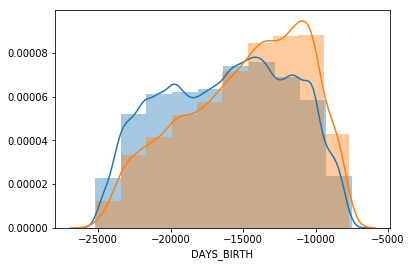

In [15]:
# DAYS_BIRTH
sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'], kde=True, rug=False, bins=10) 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


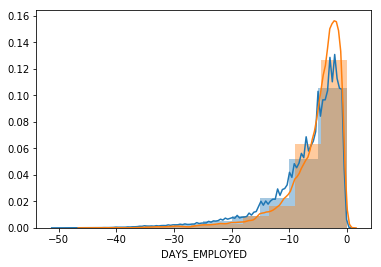

In [16]:
# DAYS_EMPLOYED
app_train.loc[app_train['DAYS_EMPLOYED'] > 50000, 'DAYS_EMPLOYED']= np.nan
app_test.loc[app_test['DAYS_EMPLOYED'] > 50000, 'DAYS_EMPLOYED']= np.nan

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] // 365 , kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] // 365 , kde=True, rug=False, bins=10) 

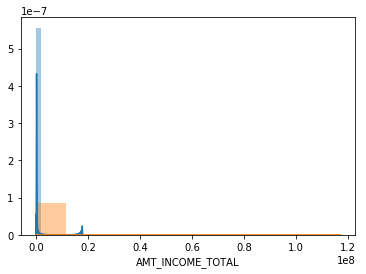

In [17]:
# AMT_INCOME_TOTAL

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_INCOME_TOTAL'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_INCOME_TOTAL'], kde=True, rug=False, bins=10) 

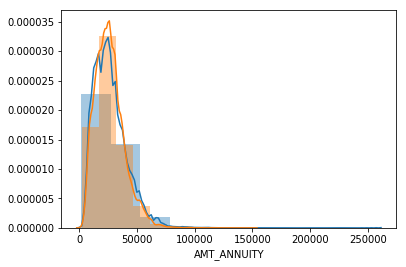

In [18]:
# AMT_ANNUITY

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_ANNUITY'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_ANNUITY'], kde=True, rug=False, bins=10) 

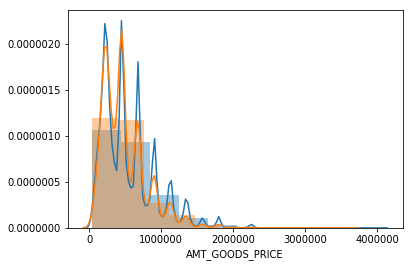

In [19]:
# AMT_GOODS_PRICE
    
sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 

In [20]:
# AMT_GOODS_PRICE
app_train['AMT_GOODS_PRICE'].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [21]:
# 前処理用に訓練データとテストデータを結合

df_app = app_train.append(app_test)

df_app = df_app[df_app['CODE_GENDER'] != 'XNA']

df_app.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(356251, 122)

In [22]:
# テーブルの結合

# bureau
df_app = df_app.merge(load_bureau_data(), on='SK_ID_CURR', how='left')

# previous_application
df_app = df_app.merge(load_prev_application_data(), on='SK_ID_CURR', how='left')

#POS_CASH_balance
df_app = df_app.merge(load_pos_cash_data(), on='SK_ID_CURR', how='left')

#installments_payments_balance
df_app = df_app.merge(load_installments_payments_data(), on='SK_ID_CURR', how='left')

#credit_card_balance
df_app = df_app.merge(load_credit_card_balance_data(), on='SK_ID_CURR', how='left')
df_app.shape

(356251, 306)

In [23]:
df_app.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_BALANCE_CNT
count,356215.000000,3.562510e+05,3.559730e+05,3.562510e+05,308683.000000,308683.000000,308683.000000,308683.000000,308683.000000,308683.000000,...,7.169200e+04,1.035580e+05,72194.000000,72194.000000,7.219400e+04,72194.000000,103558.000000,72194.000000,103558.000000,1050.000000
mean,27425.644390,5.877695e+05,5.280212e+05,1.701159e+05,0.006282,0.005809,0.231691,0.304400,0.029995,1.911544,...,1.600745e+09,1.779047e+05,583.772133,5.086295,9.531028e+03,1.760667,16.696614,6.500277,10.066951,36.822857
std,14732.860946,3.986253e+05,3.660657e+05,2.235080e+05,0.104251,0.079737,0.855940,0.786919,0.191375,1.865330,...,7.005954e+09,2.928729e+05,4518.785160,644.651543,4.890023e+04,4.282159,50.231513,11.755416,13.536168,33.046188
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.032554e+07,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10.000000
50%,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.589711e+08,6.075000e+04,0.000000,0.000000,0.000000e+00,0.052083,0.000000,1.000000,3.800000,22.000000
75%,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,1.177427e+09,2.416500e+05,0.000000,0.000000,0.000000e+00,1.468750,9.000000,8.000000,14.965517,73.000000
max,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,6.075000e+11,8.384850e+06,225000.000000,112500.000000,1.529847e+06,118.250000,2298.000000,165.000000,73.062500,106.000000


In [24]:
# Correlation

correlations = df_app[df_app['TARGET'].notnull()].corr()['TARGET'].sort_values()

print('Positive Correlations:\n', correlations.tail(20))
print('\nNegative Correlations:\n', correlations.head(20))

Positive Correlations:
 PAY_DAYS_ENTRY_PAYMENT_MIN          0.058792
REGION_RATING_CLIENT                0.058901
CC_MONTHS_BALANCE_SUM               0.059051
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN    0.059925
REGION_RATING_CLIENT_W_CITY         0.060895
CC_MONTHS_BALANCE_MEAN              0.062081
CC_AMT_BALANCE_MIN                  0.064163
CC_AMT_BALANCE_MAX                  0.068798
CC_CNT_DRAWINGS_POS_CURRENT_MAX     0.068942
DAYS_EMPLOYED                       0.074957
BUREAU_DAYS_CREDIT_MIN              0.075248
DAYS_BIRTH                          0.078242
CC_AMT_BALANCE_MEAN                 0.087177
BUREAU_DAYS_CREDIT_MEAN             0.089731
PREV_DAYS_FIRST_DRAWING_MIN         0.095787
PREV_DAYS_FIRST_DRAWING_MEAN        0.096119
PREV_DAYS_FIRST_DRAWING_MAX         0.096222
TARGET                              1.000000
BUREAU_BALANCE_CNT_SUM                   NaN
BUREAU_BALANCE_CNT_MAX                   NaN
Name: TARGET, dtype: float64

Negative Correlations:
 EXT_SOURCE_3          

In [25]:
# 不要なレコードを削除

df_app = df_app[df_app['CODE_GENDER'] != 'XNA']

In [26]:
# 外れ値をNaNに変換

df_app['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [27]:
# 特徴同士の組み合わせによる特徴量の作成
df_app['ANNUITY_INCOME_PERCENT'] = df_app['AMT_ANNUITY'] / df_app['AMT_INCOME_TOTAL']
df_app['CREDIT_ANNUITY_PERCENT'] = df_app['AMT_CREDIT'] / df_app['AMT_ANNUITY']
df_app['ANNUITY_PRICE_PERCENT'] = df_app['AMT_ANNUITY'] / df_app['AMT_GOODS_PRICE']
df_app['CREDIT_PRICE_PERCENT'] = df_app['AMT_CREDIT'] / df_app['AMT_GOODS_PRICE']

In [28]:
# clipping

num_cols = df_app.select_dtypes(include='number').columns.tolist()
print(df_app.select_dtypes(include='number').sort_index(axis=1, ascending=True).columns.tolist())

p01 = df_app[num_cols].quantile(0.01)
p99 = df_app[num_cols].quantile(0.99)

# 各列の置換
df_app[num_cols] = df_app[num_cols].clip(p01, p99, axis=1)

['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'ANNUITY_INCOME_PERCENT', 'ANNUITY_PRICE_PERCENT', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'BUREAU_AMT_ANNUITY_MAX', 'BUREAU_AMT_ANNUITY_MEAN', 'BUREAU_AMT_ANNUITY_SUM', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM', 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX', 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN', 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM', 'BUREAU_AMT_CREDIT_SUM_LIMIT_MAX', 'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN', 'BUREAU_AMT_CREDIT_SUM_LIMIT_SUM', 'BUREAU_AMT_CREDIT_SUM_MAX', 'BUREAU_AMT_CREDIT_SUM_MEAN', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BUREAU_AMT_CR

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


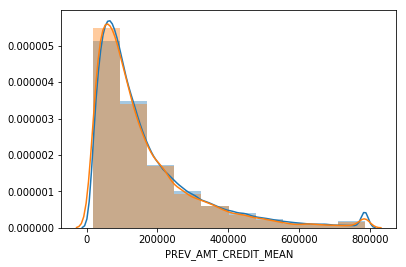

In [29]:
app_train = df_app[df_app['TARGET'].notnull()]

# 各列の置換

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'PREV_AMT_CREDIT_MEAN'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'PREV_AMT_CREDIT_MEAN'], kde=True, rug=False, bins=10) 

In [30]:
df_app.select_dtypes('object').nunique()

CODE_GENDER                          2
EMERGENCYSTATE_MODE                  2
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
FONDKAPREMONT_MODE                   4
HOUSETYPE_MODE                       3
NAME_CONTRACT_TYPE                   2
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
NAME_INCOME_TYPE                     8
NAME_TYPE_SUITE                      7
OCCUPATION_TYPE                     18
ORGANIZATION_TYPE                   58
WALLSMATERIAL_MODE                   7
WEEKDAY_APPR_PROCESS_START           7
BUREAU_CREDIT_ACTIVE                 4
BUREAU_CREDIT_CURRENCY               3
BUREAU_CREDIT_TYPE                  12
BUREAU_STATUS                        7
PREV_NAME_CONTRACT_TYPE              4
PREV_WEEKDAY_APPR_PROCESS_START      7
PREV_FLAG_LAST_APPL_PER_CONTRACT     2
PREV_NAME_CASH_LOAN_PURPOSE         25
PREV_NAME_CONTRACT_STATUS            4
PREV_NAME_PAYMENT_TYPE   

In [31]:
#targer encoding

# 再度訓練データとテストデータに分割
app_train = df_app[df_app['TARGET'].notnull()]
app_test = df_app[df_app['TARGET'].isnull()]
train_label = app_train['TARGET']

# カテゴリ列FLAG_EMP_PHONE
cat_cols = ['REGION_RATING_CLIENT_W_CITY','ORGANIZATION_TYPE']

# target encoding
for c in cat_cols:
    # 訓練データで各カテゴリにおける平均を計算
    df_tmp = pd.DataFrame({c: app_train[c], 'target': train_label})
    target_mean = df_tmp.groupby(c)['target'].mean()
    # テストデータのカテゴリを置換
    app_test[c] = app_test[c].map(target_mean)

    # 訓練データの値を格納する配列
    tmp = np.repeat(np.nan, app_train.shape[0])

    # 訓練データを分割
    kf = KFold(n_splits=4, shuffle=True, random_state=72)
    for idx_tr, idx_va in kf.split(app_train):
        # out-of-foldで各カテゴリにおける目的変数の平均を計算
        target_mean = df_tmp.iloc[idx_tr].groupby(c)['target'].mean()
        # 変換後の値を一時配列に格納
        tmp[idx_va] = app_train[c].iloc[idx_va].map(target_mean)

    # 変換後のデータで元の変数を置換
    app_train[c] = tmp
    
# 訓練データとテストデータを再結合
df_app = app_train.append(app_test).reset_index()
print(df_app[cat_cols])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


        REGION_RATING_CLIENT_W_CITY  ORGANIZATION_TYPE
0                          0.079361           0.093269
1                          0.048463           0.060317
2                          0.079361           0.071658
3                          0.079474           0.093300
4                          0.079416           0.059701
5                          0.078465           0.078522
6                          0.079416           0.094115
7                          0.113782           0.075469
8                          0.078465           0.053026
9                          0.079361           0.064698
10                         0.078465           0.064397
11                         0.078465           0.053026
12                         0.079416           0.085360
13                         0.079361           0.100149
14                         0.047561           0.075630
15                         0.114444           0.085834
16                         0.079361           0.071658
17        

In [32]:
# ラベルエンコーディング

cat_cols = [c for c in df_app.columns if df_app[c].dtype == 'object']

for col in cat_cols:
    labels, uniques = pd.factorize(df_app[col])
    df_app[col] = labels

df_app[cat_cols]

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,PREV_NAME_TYPE_SUITE,PREV_NAME_CLIENT_TYPE,PREV_NAME_GOODS_CATEGORY,PREV_NAME_PORTFOLIO,PREV_NAME_PRODUCT_TYPE,PREV_CHANNEL_TYPE,PREV_NAME_SELLER_INDUSTRY,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PAY_NAME_CONTRACT_STATUS
0,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,1,0,...,0,1,1,0,0,1,1,1,1,0
2,0,-1,1,0,-1,-1,1,0,0,0,...,1,0,2,0,0,2,2,1,2,0
3,1,-1,0,0,-1,-1,0,0,2,0,...,1,2,3,1,0,3,3,2,3,0
4,0,-1,0,0,-1,-1,0,0,0,0,...,0,2,3,1,1,1,1,3,4,0
5,0,-1,0,0,-1,-1,0,0,1,0,...,1,2,3,0,0,1,1,0,5,0
6,1,-1,1,0,-1,-1,0,1,1,0,...,0,2,4,0,0,2,1,1,5,0
7,0,-1,1,0,-1,-1,0,1,1,0,...,0,0,5,0,0,0,4,4,6,0
8,1,-1,0,0,-1,-1,0,0,1,0,...,1,2,3,2,0,3,3,2,7,0
9,0,-1,0,0,-1,-1,1,0,0,0,...,0,2,3,1,0,3,3,3,8,0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.756315	training's binary_logloss: 0.254213	valid_1's auc: 0.745504	valid_1's binary_logloss: 0.255964
[200]	training's auc: 0.776222	training's binary_logloss: 0.244672	valid_1's auc: 0.760646	valid_1's binary_logloss: 0.248408
[300]	training's auc: 0.790065	training's binary_logloss: 0.238807	valid_1's auc: 0.770716	valid_1's binary_logloss: 0.244333
[400]	training's auc: 0.799616	training's binary_logloss: 0.23474	valid_1's auc: 0.776576	valid_1's binary_logloss: 0.241927
[500]	training's auc: 0.806898	training's binary_logloss: 0.231568	valid_1's auc: 0.780518	valid_1's binary_logloss: 0.24029
[600]	training's auc: 0.813172	training's binary_logloss: 0.228901	valid_1's auc: 0.783399	valid_1's binary_logloss: 0.239131
[700]	training's auc: 0.818599	training's binary_logloss: 0.226603	valid_1's auc: 0.785379	valid_1's binary_logloss: 0.238317
[800]	training's auc: 0.823296	training's binary_logloss: 

[600]	training's auc: 0.813731	training's binary_logloss: 0.228583	valid_1's auc: 0.781013	valid_1's binary_logloss: 0.239972
[700]	training's auc: 0.81903	training's binary_logloss: 0.226339	valid_1's auc: 0.783052	valid_1's binary_logloss: 0.239162
[800]	training's auc: 0.823744	training's binary_logloss: 0.224357	valid_1's auc: 0.784673	valid_1's binary_logloss: 0.238532
[900]	training's auc: 0.828079	training's binary_logloss: 0.222543	valid_1's auc: 0.785879	valid_1's binary_logloss: 0.238079
[1000]	training's auc: 0.832185	training's binary_logloss: 0.22087	valid_1's auc: 0.786818	valid_1's binary_logloss: 0.23773
[1100]	training's auc: 0.836007	training's binary_logloss: 0.219269	valid_1's auc: 0.787474	valid_1's binary_logloss: 0.237473
[1200]	training's auc: 0.839608	training's binary_logloss: 0.217773	valid_1's auc: 0.788029	valid_1's binary_logloss: 0.237281
[1300]	training's auc: 0.843083	training's binary_logloss: 0.216315	valid_1's auc: 0.788403	valid_1's binary_logloss: 

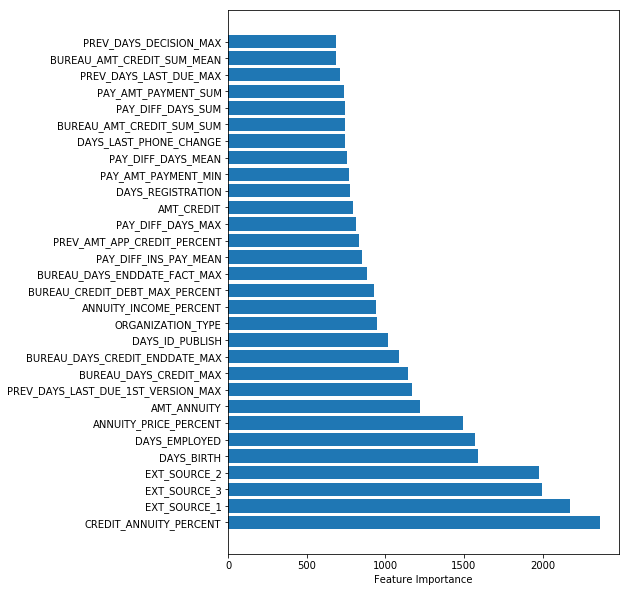

array([0.02851187, 0.03280868, 0.01909454, ..., 0.01289067, 0.00547527,
       0.05587724])

In [33]:
# 学習データを4分割し、学習・評価を行う
kfold_lightgbm(df_app)

In [34]:
import time

# 目的変数をシャッフルしない場合
app_train = df_app[df_app['TARGET'].notnull()]
test_X = df_app[df_app['TARGET'].isnull()]

# 特徴量と目的変数に分離
train_label = app_train['TARGET']
app_train.drop(['TARGET'], axis=1, inplace=True)

# 不要な特徴量をドロップ
app_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
test_X.drop(['SK_ID_CURR'], axis=1, inplace=True)

act_imp_df = get_feature_importances(app_train, train_label, shuffle=False)

# 目的変数をシャッフルする場合
n_runs = 80
start = time.time()
null_imp_df = pd.DataFrame()
for i in range(n_runs):
    imp_df = get_feature_importances(app_train, train_label, shuffle=True)
    imp_df["run"] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df])
    spent = (time.time() - start) / 60
    print('Done with %4d of %4d (Spent %5.1f min)' % (i + 1, n_runs, spent))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Done with    1 of   80 (Spent   0.9 min)
Done with    2 of   80 (Spent   2.0 min)
Done with    3 of   80 (Spent   3.0 min)
Done with    4 of   80 (Spent   3.9 min)
Done with    5 of   80 (Spent   4.8 min)
Done with    6 of   80 (Spent   5.8 min)
Done with    7 of   80 (Spent   6.8 min)
Done with    8 of   80 (Spent   7.8 min)
Done with    9 of   80 (Spent   8.9 min)
Done with   10 of   80 (Spent  10.0 min)
Done with   11 of   80 (Spent  10.8 min)
Done with   12 of   80 (Spent  11.7 min)
Done with   13 of   80 (Spent  12.6 min)
Done with   14 of   80 (Spent  13.5 min)
Done with   15 of   80 (Spent  14.3 min)
Done with   16 of   80 (Spent  15.2 min)
Done with   17 of   80 (Spent  16.0 min)
Done with   18 of   80 (Spent  16.9 min)
Done with   19 of   80 (Spent  18.1 min)
Done with   20 of   80 (Spent  19.0 min)
Done with   21 of   80 (Spent  20.1 min)
Done with   22 of   80 (Spent  21.2 min)
Done with   23 of   80 (Spent  22.0 min)
Done with   24 of   80 (Spent  22.9 min)
Done with   25 o

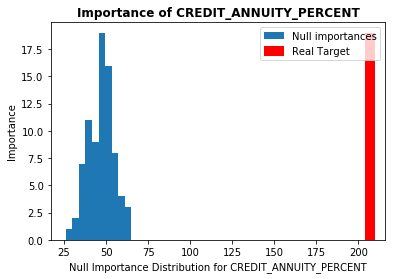

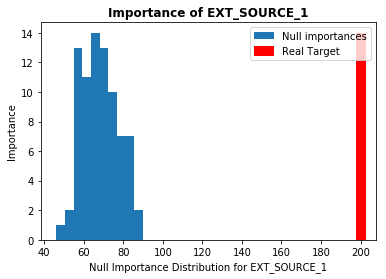

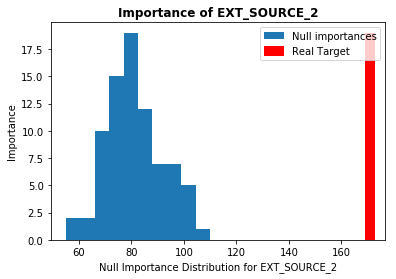

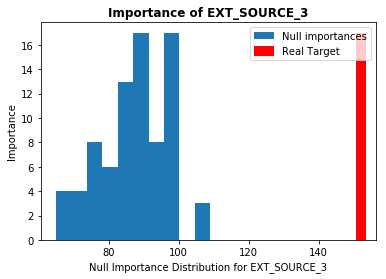

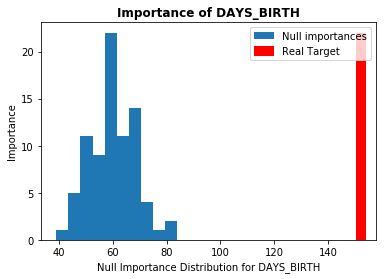

In [35]:
# 重要度が上位5位の特徴量を表示
for feature in act_imp_df["feature"][:5]:
    display_distributions(act_imp_df, null_imp_df, feature)

In [36]:
# 特徴量選択

# 閾値
threshold = 75

# 閾値を超える特徴量を抽出
important_features = []
for feature in act_imp_df["feature"]:
    act_val = act_imp_df.loc[act_imp_df['feature'] == feature, 'importance'].values
    null_val = null_imp_df.loc[null_imp_df['feature'] == feature, 'importance'].values
    percentage = (null_val < act_val).sum() / null_val.size * 100
    if percentage >= threshold:
        important_features.append(feature)

print(important_features)

['CREDIT_ANNUITY_PERCENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'ANNUITY_PRICE_PERCENT', 'PREV_DAYS_LAST_DUE_1ST_VERSION_MAX', 'BUREAU_DAYS_CREDIT_MAX', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'PAY_AMT_PAYMENT_SUM', 'PAY_DIFF_DAYS_MAX', 'BUREAU_DAYS_CREDIT_ENDDATE_MAX', 'PAY_DIFF_INS_PAY_MEAN', 'BUREAU_CREDIT_DEBT_MAX_PERCENT', 'ORGANIZATION_TYPE', 'BUREAU_CREDIT_DEBT_MEAN_PERCENT', 'BUREAU_AMT_CREDIT_SUM_MAX', 'BUREAU_DAYS_CREDIT_MEAN', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'PREV_CNT_PAYMENT_SUM', 'PREV_CNT_PAYMENT_MEAN', 'CC_AMT_BALANCE_MEAN', 'PAY_DIFF_INS_PAY_SUM', 'PAY_AMT_PAYMENT_MEAN', 'POS_SK_DPD_DEF_MEAN', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX', 'NAME_FAMILY_STATUS', 'CODE_GENDER', 'PAY_AMT_INSTALMENT_MAX', 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM', 'NAME_EDUCATION_TYPE', 'CC_AMT_BALANCE_MAX', 'CC_CNT_DRAWINGS_POS_CURRENT_MAX', 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM', 'CC_AMT_CREDIT_L

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.755101	training's binary_logloss: 0.254461	valid_1's auc: 0.744803	valid_1's binary_logloss: 0.256122
[200]	training's auc: 0.773529	training's binary_logloss: 0.24535	valid_1's auc: 0.758632	valid_1's binary_logloss: 0.248843
[300]	training's auc: 0.786914	training's binary_logloss: 0.239674	valid_1's auc: 0.769344	valid_1's binary_logloss: 0.244647
[400]	training's auc: 0.795873	training's binary_logloss: 0.235865	valid_1's auc: 0.775304	valid_1's binary_logloss: 0.24223
[500]	training's auc: 0.802346	training's binary_logloss: 0.233015	valid_1's auc: 0.778971	valid_1's binary_logloss: 0.240741
[600]	training's auc: 0.807725	training's binary_logloss: 0.230703	valid_1's auc: 0.781759	valid_1's binary_logloss: 0.239644
[700]	training's auc: 0.812258	training's binary_logloss: 0.228745	valid_1's auc: 0.783612	valid_1's binary_logloss: 0.238893
[800]	training's auc: 0.816292	training's binary_logloss: 

[300]	training's auc: 0.787165	training's binary_logloss: 0.239478	valid_1's auc: 0.767705	valid_1's binary_logloss: 0.245186
[400]	training's auc: 0.796034	training's binary_logloss: 0.235692	valid_1's auc: 0.773875	valid_1's binary_logloss: 0.242718
[500]	training's auc: 0.802707	training's binary_logloss: 0.232818	valid_1's auc: 0.777976	valid_1's binary_logloss: 0.241071
[600]	training's auc: 0.807974	training's binary_logloss: 0.230549	valid_1's auc: 0.78076	valid_1's binary_logloss: 0.23996
[700]	training's auc: 0.812463	training's binary_logloss: 0.228646	valid_1's auc: 0.782725	valid_1's binary_logloss: 0.239174
[800]	training's auc: 0.816475	training's binary_logloss: 0.226977	valid_1's auc: 0.784405	valid_1's binary_logloss: 0.238532
[900]	training's auc: 0.820101	training's binary_logloss: 0.225458	valid_1's auc: 0.785775	valid_1's binary_logloss: 0.238028
[1000]	training's auc: 0.823451	training's binary_logloss: 0.224063	valid_1's auc: 0.786724	valid_1's binary_logloss: 0.

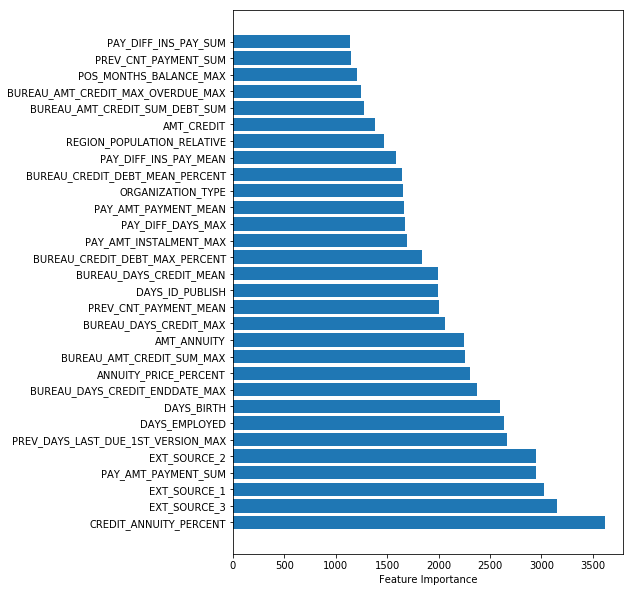

In [37]:
# 学習データを4分割し、学習・評価を行う
sub_preds = kfold_lightgbm(df_app, important_features)

In [38]:
print(sub_preds)

[0.03745378 0.11689828 0.02327619 ... 0.01223007 0.0267842  0.18061673]


In [39]:
# datasetsディレクトリに結果を出力

result_out = load_home_credit_data("application_test.csv")
result_out["TARGET"] = sub_preds 
print(result_out[["SK_ID_CURR","TARGET"]])

submission_path = os.path.join(HOME_CREDIT_PATH, "home_credit_submission.csv")
result_out[["SK_ID_CURR","TARGET"]].to_csv(submission_path,index=False)

       SK_ID_CURR    TARGET
0          100001  0.037454
1          100005  0.116898
2          100013  0.023276
3          100028  0.037565
4          100038  0.113115
5          100042  0.037182
6          100057  0.013190
7          100065  0.042865
8          100066  0.018200
9          100067  0.062325
10         100074  0.047382
11         100090  0.041769
12         100091  0.224006
13         100092  0.063430
14         100106  0.055870
15         100107  0.198908
16         100109  0.059275
17         100117  0.025591
18         100128  0.124711
19         100141  0.030808
20         100150  0.042139
21         100168  0.009956
22         100169  0.025202
23         100170  0.207252
24         100171  0.053763
25         100172  0.092043
26         100184  0.066937
27         100187  0.086270
28         100212  0.043760
29         100222  0.061265
...           ...       ...
48714      455963  0.038773
48715      455965  0.008774
48716      456007  0.224975
48717      456008  0